# EchoBot Data Processing Pipeline

**Annotated notebook for EchoBot data processing**  
Emmett Culhane — Translated from MATLAB (`echobot_pipeline_SCRIPTED.m`)

The goal of this notebook is to produce and evaluate the ts(f) interference pattern for standard targets observed by EchoBot in CRL tank testing. We are working towards building an end-to-end process for raw EchoBot voltages to key metrics including target location / range, mean ts, ts(f) and the SNR.

In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import firwin, lfilter, correlate, hilbert, spectrogram
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

## 1 — Load data file

09/04/2025 ‖ 38 & 22 mm targets ‖ 3 dB ‖ stationary target ‖ downsweep

In [2]:
mat_file = 'Data/backcyl_bis_rgh0.01271_T143330_100.mat'

S = sio.loadmat(mat_file, squeeze_me=False)

# ---- Data & header ----
data = S['data']                        # (Ns, 5, Npings)
header = S['header'][0, 0]              # structured array -> scalar record

fs = float(header['fs'].flat[0])        # Hz
c  = float(header['c'].flat[0]) if 'c' in header.dtype.names else 1486.0  # m/s
rx_chans = [0, 1, 2]                    # sectors 1-3 (0-indexed)

print(f'fs = {fs/1e3:.1f} kHz   c = {c:.1f} m/s')
print(f'data shape: {data.shape}  ->  Ns={data.shape[0]}, channels={data.shape[1]}, Npings={data.shape[2]}')

fs = 2000.0 kHz   c = 1486.0 m/s
data shape: (101003, 5, 100)  ->  Ns=101003, channels=5, Npings=100


In [4]:
from pprint import pprint
pprint(S['header']) 

array([[(array([[0.0127]]), array([[100]], dtype=uint8), array([[739864.60560154]]), array([[2000000]], dtype=int32), array([[0.00066667]]), array([[3]], dtype=uint8), array([[5]], dtype=uint8), array([[5]], dtype=uint8), array([[1]], dtype=uint8), array([[0, 1, 2, 3, 4]], dtype=uint8), array([[0, 1]], dtype=uint8), array(['flume_echobot_data'], dtype='<U18'), array([[90000]], dtype=int32), array([[150000]], dtype=int32), array([[0.0005]]), array([[1.e-06]]), array([[0.05]]), array([[ 0.        ],
               [ 0.00089357],
               [ 0.00636253],
               ...,
               [-0.00421768],
               [-0.0005494 ],
               [-0.        ]], shape=(1001, 1)), array([[1486]], dtype=uint16))                                                                                                                                                                                                                                                                                      

## 2 — Build axes and transmit reference chirp

In [5]:
Ns = data.shape[0]
t = np.arange(Ns) / fs                                  # time axis (s)

T_pre  = float(header['T_pre'].flat[0])
T_post = float(header['T_post'].flat[0])
R = 0.5 * c * (t - T_pre)                               # range axis (m)

# ---- Tx reference chirp ----
s_chirp = header['s_chirp'].flatten()
T_chirp = len(s_chirp) / fs

n_pre  = int(round(T_pre  * fs))
n_post = int(round(T_post * fs))
tx_ref = np.concatenate([np.zeros(n_pre), s_chirp, np.zeros(n_post)])

print(f'T_chirp = {T_chirp*1e3:.2f} ms   tx_ref length = {len(tx_ref)}')

T_chirp = 0.50 ms   tx_ref length = 101003


## 3 — Sanity check: transmit chirp spectrogram

Verify the chirp direction (downsweep for the 09/04 data).

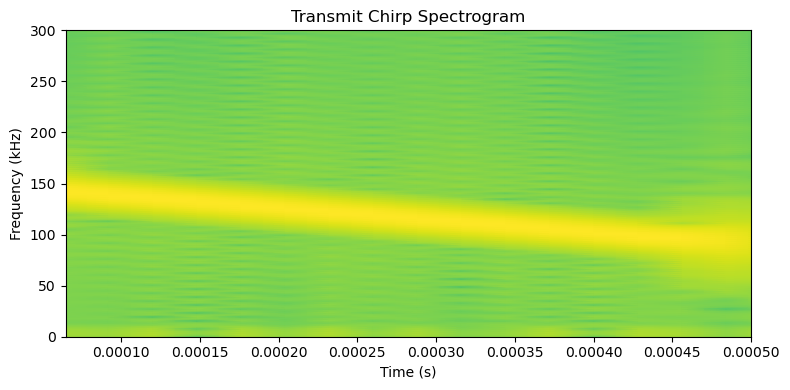

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
window = np.hamming(256)
f_spec, t_spec, Sxx = spectrogram(tx_ref, fs=fs, window=window, noverlap=200, nfft=1024)
ax.pcolormesh(t_spec, f_spec / 1e3, 10 * np.log10(Sxx + 1e-30), shading='gouraud')
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
ax.set_title('Transmit Chirp Spectrogram')
ax.set_xlim([0.000065, 0.0005])
ax.set_ylim([0, 300])      # kHz
plt.tight_layout()
plt.show()

## 4 — Find strongest / first / last ping indices

We see here that the ping IDX for the strongest ping matches the 1-based index value obtained in the matlab script (e.g. 59)

In [7]:
Npings = data.shape[2]

s = np.array([
    np.median(np.sqrt(np.mean(np.abs(data[:, :, p]) ** 2, axis=0)))
    for p in range(Npings)
])

start_idx = 0                                    # first ping (0-indexed)
end_idx   = Npings - 1                           # last ping
max_idx   = np.argmax(s[1:-1]) + 1               # strongest (excl. endpoints)

print(f'start_idx = {start_idx},  end_idx = {end_idx},  max_idx = {max_idx}')

start_idx = 0,  end_idx = 99,  max_idx = 58


## 5 — Matched filter processing

Using the **first ping** (`start_idx`).  
Band-pass via cascaded HP + LP FIR filters, then cross-correlate with `tx_ref`.

In [8]:
# Select the first ping
ping_idx = start_idx

# ---- Design FIR filters (matching MATLAB designfilt specs) ----
# Low-pass: passband 150 kHz, stopband 200 kHz
lp_numtaps = 101
lp_cutoff  = 175e3            # midpoint between pass & stop
lp_coeff   = firwin(lp_numtaps, lp_cutoff, fs=fs)

# High-pass: passband 90 kHz, stopband 70 kHz
hp_numtaps = 101
hp_cutoff  = 80e3             # midpoint between stop & pass
hp_coeff   = firwin(hp_numtaps, hp_cutoff, fs=fs, pass_zero=False)

def bandpass_filter(x):
    """Apply LP then HP (same order as MATLAB code)."""
    return lfilter(hp_coeff, 1.0, lfilter(lp_coeff, 1.0, x))

df1 = bandpass_filter(data[:, 0, ping_idx])
df2 = bandpass_filter(data[:, 1, ping_idx])
df3 = bandpass_filter(data[:, 2, ping_idx])

# ---- Cross-correlation with tx_ref ----
c1 = correlate(df1, tx_ref, mode='full')
c2 = correlate(df2, tx_ref, mode='full')
c3 = correlate(df3, tx_ref, mode='full')

# Lag vector (same convention as MATLAB xcorr)
n_df  = len(df1)
n_ref = len(tx_ref)
lags  = np.arange(-(n_ref - 1), n_df)     # full correlation lags

idx_pos = lags >= 0
Rmf = 0.5 * c * (lags[idx_pos] / fs)      # range axis for MF output
C   = np.column_stack([c1[idx_pos], c2[idx_pos], c3[idx_pos]])   # (N, 3)
cc_dB = 20 * np.log10(np.abs(hilbert(C, axis=0)) + 1e-30)

print(f'MF output shape: {C.shape}')

MF output shape: (101003, 3)


## 6 — Voltage time series (filtered, per sector)

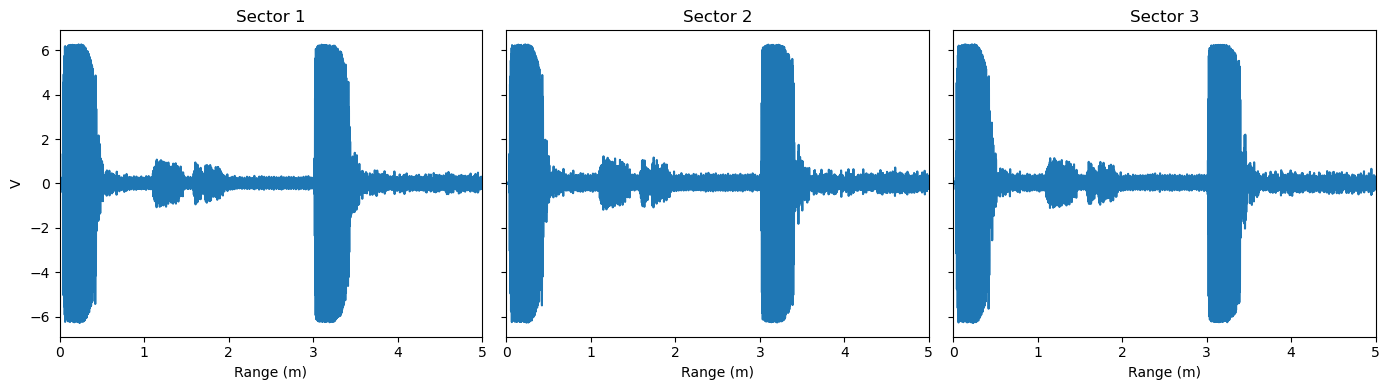

In [9]:
Range = 0.5 * c * (t - T_pre)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for ax, sig, ch in zip(axes, [df1, df2, df3], [1, 2, 3]):
    ax.plot(Range, sig)
    ax.set_xlim([0, 5])
    ax.set_title(f'Sector {ch}')
    ax.set_xlabel('Range (m)')
axes[0].set_ylabel('V')
plt.tight_layout()
plt.show()

## 7 — Matched filter output (dB vs range)

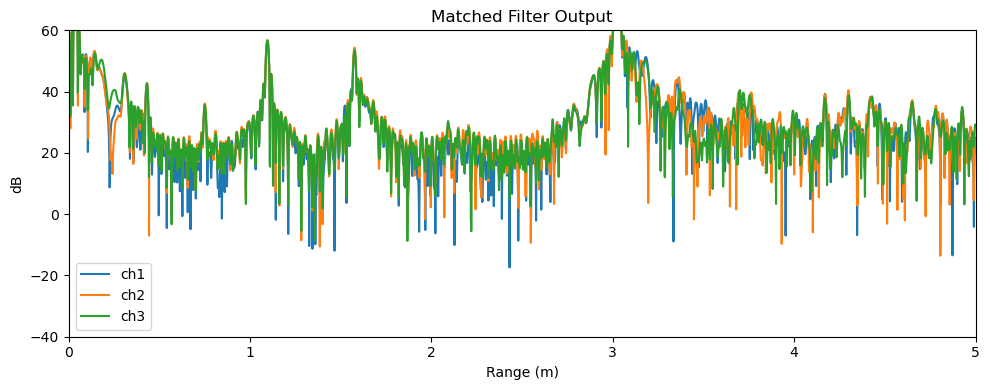

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Rmf, cc_dB)
ax.set_xlim([0, 5])
ax.set_ylim([-40, 60])
ax.set_xlabel('Range (m)')
ax.set_ylabel('dB')
ax.set_title('Matched Filter Output')
ax.legend(['ch1', 'ch2', 'ch3'])
plt.tight_layout()
plt.show()

## 8 — Define range windows (noise & target gates)

**Noise window** (`noise_approx`): centred at 0.6 m, half-width 0.1 m  
**38 mm target window** (`target_38mm`): centred at 1.57 m, half-width 0.25 m  

Hard-coded for CRL test 09/04/2025.

In [11]:
# ---- Noise window ----
noise_approx_center = 0.6
noise_approx_half   = 0.1
noise_approx_band   = [noise_approx_center - noise_approx_half,
                        noise_approx_center + noise_approx_half]

# ---- 38 mm target window ----
target_38mm_center = 1.57
target_38mm_half   = 0.25
target_38mm_band   = [target_38mm_center - target_38mm_half,
                      target_38mm_center + target_38mm_half]

print(f'Noise band:      {noise_approx_band}')
print(f'38 mm target band: {target_38mm_band}')

Noise band:      [0.5, 0.7]
38 mm target band: [1.32, 1.82]


## 9 — Plot MF envelope with range gates

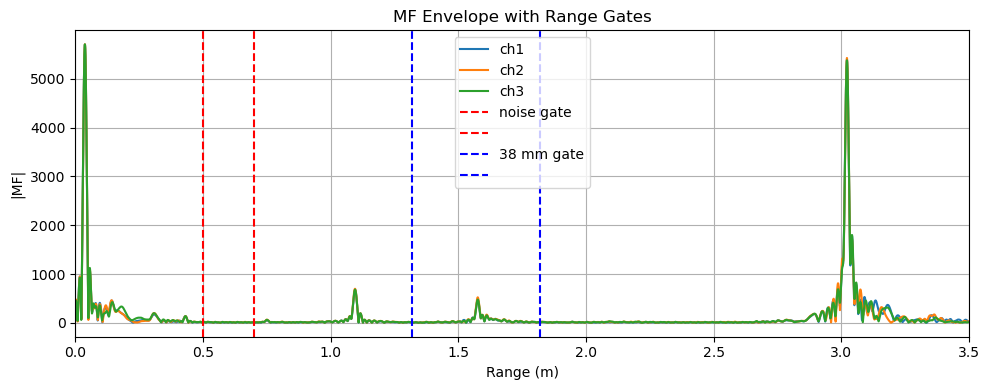

In [12]:
MFmag = np.abs(hilbert(C, axis=0))       # envelope of MF per channel

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Rmf, MFmag)
ax.axvline(noise_approx_band[0], color='r', ls='--', label='noise gate')
ax.axvline(noise_approx_band[1], color='r', ls='--')
ax.axvline(target_38mm_band[0],  color='b', ls='--', label='38 mm target gate')
ax.axvline(target_38mm_band[1],  color='b', ls='--')
ax.set_xlim([0, 3.5])
ax.set_xlabel('Range (m)')
ax.set_ylabel('|MF|')
ax.set_title('MF Envelope with Range Gates')
ax.legend(['ch1', 'ch2', 'ch3', 'noise gate', '', '38 mm gate', ''])
ax.grid(True)
plt.tight_layout()
plt.show()

## 10 — FFT: ts(f) approximation (noise vs 38 mm target, per sector)

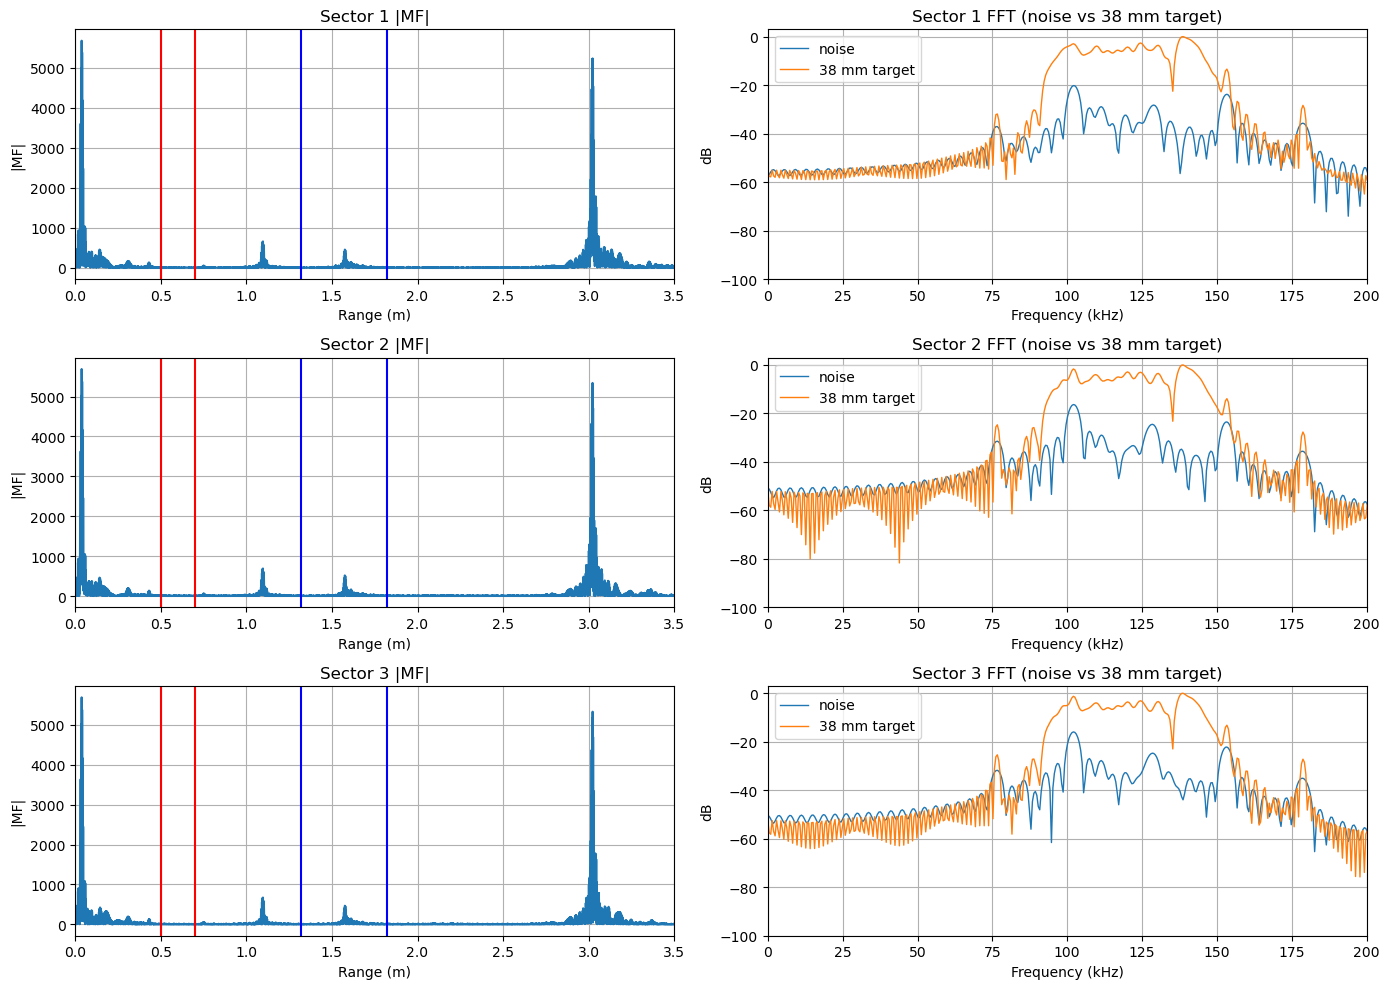

In [13]:
Nfft = 4096
f_Hz = np.arange(Nfft) * (fs / Nfft)

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for ch in range(3):
    m = C[:, ch]                                       # MF for this sector

    # Noise gate indices
    j0n = np.searchsorted(Rmf, noise_approx_band[0])
    j1n = np.searchsorted(Rmf, noise_approx_band[1], side='right') - 1

    # Target gate indices
    j0f = np.searchsorted(Rmf, target_38mm_band[0])
    j1f = np.searchsorted(Rmf, target_38mm_band[1], side='right') - 1

    FFTn = np.fft.fft(m[j0n:j1n+1], n=Nfft)
    FFTf = np.fft.fft(m[j0f:j1f+1], n=Nfft)

    all_max = np.max(np.abs(np.concatenate([FFTn, FFTf]))) + 1e-30
    SdB_n = 20 * np.log10(np.abs(FFTn) / all_max)
    SdB_f = 20 * np.log10(np.abs(FFTf) / all_max)

    # Left: |MF| vs range with gates
    ax_l = axes[ch, 0]
    ax_l.plot(Rmf, np.abs(m))
    ax_l.axvline(noise_approx_band[0], color='r')
    ax_l.axvline(noise_approx_band[1], color='r')
    ax_l.axvline(target_38mm_band[0],  color='b')
    ax_l.axvline(target_38mm_band[1],  color='b')
    ax_l.set_xlim([0, 3.5])
    ax_l.grid(True)
    ax_l.set_title(f'Sector {ch+1} |MF|')
    ax_l.set_xlabel('Range (m)')
    ax_l.set_ylabel('|MF|')

    # Right: FFT spectra (noise vs target)
    ax_r = axes[ch, 1]
    ax_r.plot(f_Hz / 1e3, SdB_n, linewidth=1, label='noise')
    ax_r.plot(f_Hz / 1e3, SdB_f, linewidth=1, label='38 mm target')
    ax_r.grid(True)
    ax_r.set_xlim([0, 200])
    ax_r.set_ylim([-100, 3])
    ax_r.set_xlabel('Frequency (kHz)')
    ax_r.set_ylabel('dB')
    ax_r.set_title(f'Sector {ch+1} FFT (noise vs 38 mm target)')
    ax_r.legend(loc='best')

plt.tight_layout()
plt.show()